<a href="https://colab.research.google.com/github/greek-nlp/benchmark/blob/main/impostors_krikri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Krikri

In [1]:
%%capture
!pip install torch transformers accelerate

In [8]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

# Set the model ID and the device
model_id = "ilsp/Llama-Krikri-8B-Instruct"
device = "cuda" # or "cpu" if you have a powerful CPU and limited VRAM

try:
    # Loading the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_id)

    # Load the model
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        dtype=torch.bfloat16, # Using bfloat16 for efficiency on supported GPUs
        device_map="auto"     # Automatically distributing the model across available devices
    )
    model.to(device)

    # Prepare your instruction/prompt
    prompt = "Ποια είναι η πρωτεύουσα της Ελλάδας;" # "What is the capital of Greece?"

    # Apply the chat template for the Instruct model
    messages = [
        {"role": "user", "content": prompt}
    ]
    input_ids = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to(device)

    # Generate the response
    outputs = model.generate(
        input_ids,
        max_new_tokens=256,
        do_sample=True,
        temperature=0.7,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode and print the result
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(response)

except OSError as e:
    print(f"Error loading the model or tokenizer: {e}")
    print("This might be due to network issues or problems accessing the model files on Hugging Face.")
    print("Please try running the cell again later.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

tokenizer.json:   0%|          | 0.00/19.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/955 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


system

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

user

Ποια είναι η πρωτεύουσα της Ελλάδας;assistant

Η πρωτεύουσα της Ελλάδας είναι η Αθήνα.


In [9]:
def prompt_krikri(model, prompt, system_prompt, temperature=0.3):
  messages = [
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": prompt},
  ]

  input_ids = tokenizer.apply_chat_template(
      messages,
      tokenize=True,
      add_generation_prompt=True,
      return_tensors="pt"
  ).to(device)

  outputs = model.generate(
      input_ids,
      max_new_tokens=16,
      do_sample=True,
      temperature=temperature,
      pad_token_id=tokenizer.eos_token_id
  )
  #response = tokenizer.decode(outputs[0], skip_special_tokens=True)
  # In Classification Decoding Mode
  full_response = tokenizer.decode(outputs[0], skip_special_tokens=False)

  assistant_prefix = "<|start_header_id|>assistant<|end_header_id|>"
  response = full_response.split(assistant_prefix)[-1].strip()

  # Finally, remove the end-of-turn token if it appears
  response = response.replace("<|eot_id|>", "").strip()

  return response

# Data access

In [6]:
!gdown 17Ks0Q8GFsunj5w3PoHwcG1vTm_bfLhpL

In [7]:
import pandas as pd
barzokas_pop = pd.read_csv('barzokas_10excerpts.csv.gz', index_col=0)
pop_authors = barzokas_pop.author.value_counts().index.tolist()
pop_authors

['Θανάσης Τριαρίδης',
 'Γιάννης Αντάμης',
 'Πάνος Κολιόπουλος',
 'Κώστας Βουλαζέρης',
 'Δημήτρης Τζουβάλης',
 'Plato',
 'Ράνια Συνοδινού',
 'Γιώργος Σ. Κόκκινος',
 'Ευρυδίκη Αμανατίδου',
 'Πάνος Α. Ζέρβας',
 'Φρίντα Κριτσωτάκη',
 'Πασχάλης Παπαβασιλείου',
 'Αύγουστος Κορτώ',
 'Χάρης Γαντζούδης',
 'Βασίλειος Κάππας',
 'Τέος Ρόμβος',
 'Κατερίνα Καζολέα']

In [10]:
from tqdm.notebook import tqdm
instruct = "Given an excerpt from a Greek book, return the author it is from by picking from the following authors: " + ', '.join(pop_authors) +' Return only the name of the author, nothing else.'
for i in tqdm(range(1, 11)):
  barzokas_pop[f'krikri_{i}'] = [prompt_krikri(model, t, instruct) for t in tqdm(barzokas_pop[f'excerpt_{i}'].values)]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

In [11]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
barzokas_pop_mini = barzokas_pop[:175]
p,r,f = [],[],[]
for i in range(1,11):
  p.append(precision_score(barzokas_pop_mini.author, barzokas_pop_mini[f'krikri_{i}'].str.strip(), labels=pop_authors, zero_division=0, average='macro'))
  r.append(recall_score(barzokas_pop_mini.author, barzokas_pop_mini[f'krikri_{i}'].str.strip(), labels=pop_authors, zero_division=0, average='macro'))
  f.append(f1_score(barzokas_pop_mini.author, barzokas_pop_mini[f'krikri_{i}'].str.strip(), labels=pop_authors, zero_division=0, average='macro'))

print(f'P: {pd.Series(p).mean():.3f} ({pd.Series(p).sem():.3f})')
print(f'R: {pd.Series(r).mean():.3f} ({pd.Series(r).sem():.3f})')
print(f'F: {pd.Series(f).mean():.3f} ({pd.Series(f).sem():.3f})')


P: 0.394 (0.020)
R: 0.182 (0.005)
F: 0.175 (0.007)


In [ ]:
barzokas_pop_mini.to_csv('barzokas_krikri.csv')

In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

num_runs = 10
num_samples = 175
np.random.seed(42)

author_metrics = {
    author: {'P': [], 'R': [], 'F': []} for author in pop_authors
}

for i in range(1, 11):
    pred_col = f'krikri_{i}'
    y_true = barzokas_pop_mini['author']
    y_pred = barzokas_pop_mini[pred_col].str.strip() # Ensure stripping is applied here

    # Get the classification report dictionary for the current run
    report = classification_report(
        y_true,
        y_pred,
        labels=pop_authors,
        zero_division=0,
        output_dict=True
    )

    # Store P, R, F scores for each individual author
    for author in pop_authors:
        if author in report:
            author_metrics[author]['P'].append(report[author]['precision'])
            author_metrics[author]['R'].append(report[author]['recall'])
            author_metrics[author]['F'].append(report[author]['f1-score'])

# 3. Calculate Mean and SEM for each author's metrics
results = {}
for author, metrics in author_metrics.items():
    results[author] = {
        'P_mean': np.mean(metrics['P']),
        'P_sem': pd.Series(metrics['P']).sem(),
        'R_mean': np.mean(metrics['R']),
        'R_sem': pd.Series(metrics['R']).sem(),
        'F_mean': np.mean(metrics['F']),
        'F_sem': pd.Series(metrics['F']).sem()
    }

# 4. Report the results
print("--- Mean (SEM) Performance Per Author Across 10 Runs ---")
for author in pop_authors:
    res = results[author]
    print(f"\nAuthor: {author}")
    print(f"  P: {res['P_mean']:.3f} ({res['P_sem']:.3f})")
    print(f"  R: {res['R_mean']:.3f} ({res['R_sem']:.3f})")
    print(f"  F1: {res['F_mean']:.3f} ({res['F_sem']:.3f})")

# Optionally, you can also format the final macro-average results from the initial prompt:
p_macro = [np.mean(author_metrics[a]['P']) for a in pop_authors]
r_macro = [np.mean(author_metrics[a]['R']) for a in pop_authors]
f_macro = [np.mean(author_metrics[a]['F']) for a in pop_authors]

macro_p_mean = np.mean(p_macro)
macro_r_mean = np.mean(r_macro)
macro_f_mean = np.mean(f_macro)

# Recalculating SEM for the macro scores based on the 10 macro scores (as in your original code)
p_sem = pd.Series([np.mean(author_metrics[a]['P']) for a in pop_authors]).sem()
r_sem = pd.Series([np.mean(author_metrics[a]['R']) for a in pop_authors]).sem()
f_sem = pd.Series([np.mean(author_metrics[a]['F']) for a in pop_authors]).sem()

print("\n--- Overall Macro-Averages (10-Run Mean) ---")
print(f"P: {macro_p_mean:.3f} ({p_sem:.3f})")
print(f"R: {macro_r_mean:.3f} ({r_sem:.3f})")
print(f"F: {macro_f_mean:.3f} ({f_sem:.3f})")

--- Mean (SEM) Performance Per Author Across 10 Runs ---

Author: Θανάσης Τριαρίδης
  P: 0.783 (0.099)
  R: 0.079 (0.013)
  F1: 0.141 (0.022)

Author: Γιάννης Αντάμης
  P: 0.400 (0.163)
  R: 0.017 (0.007)
  F1: 0.033 (0.014)

Author: Πάνος Κολιόπουλος
  P: 0.100 (0.100)
  R: 0.006 (0.006)
  F1: 0.011 (0.011)

Author: Κώστας Βουλαζέρης
  P: 1.000 (0.000)
  R: 0.147 (0.018)
  F1: 0.252 (0.028)

Author: Δημήτρης Τζουβάλης
  P: 0.980 (0.020)
  R: 0.285 (0.030)
  F1: 0.433 (0.037)

Author: Plato
  P: 0.054 (0.001)
  R: 1.000 (0.000)
  F1: 0.103 (0.001)

Author: Ράνια Συνοδινού
  P: 0.000 (0.000)
  R: 0.000 (0.000)
  F1: 0.000 (0.000)

Author: Γιώργος Σ. Κόκκινος
  P: 1.000 (0.000)
  R: 0.450 (0.020)
  F1: 0.618 (0.020)

Author: Ευρυδίκη Αμανατίδου
  P: 0.700 (0.153)
  R: 0.129 (0.033)
  F1: 0.214 (0.053)

Author: Πάνος Α. Ζέρβας
  P: 0.000 (0.000)
  R: 0.000 (0.000)
  F1: 0.000 (0.000)

Author: Φρίντα Κριτσωτάκη
  P: 0.000 (0.000)
  R: 0.000 (0.000)
  F1: 0.000 (0.000)

Author: Πασχάλης Παπ

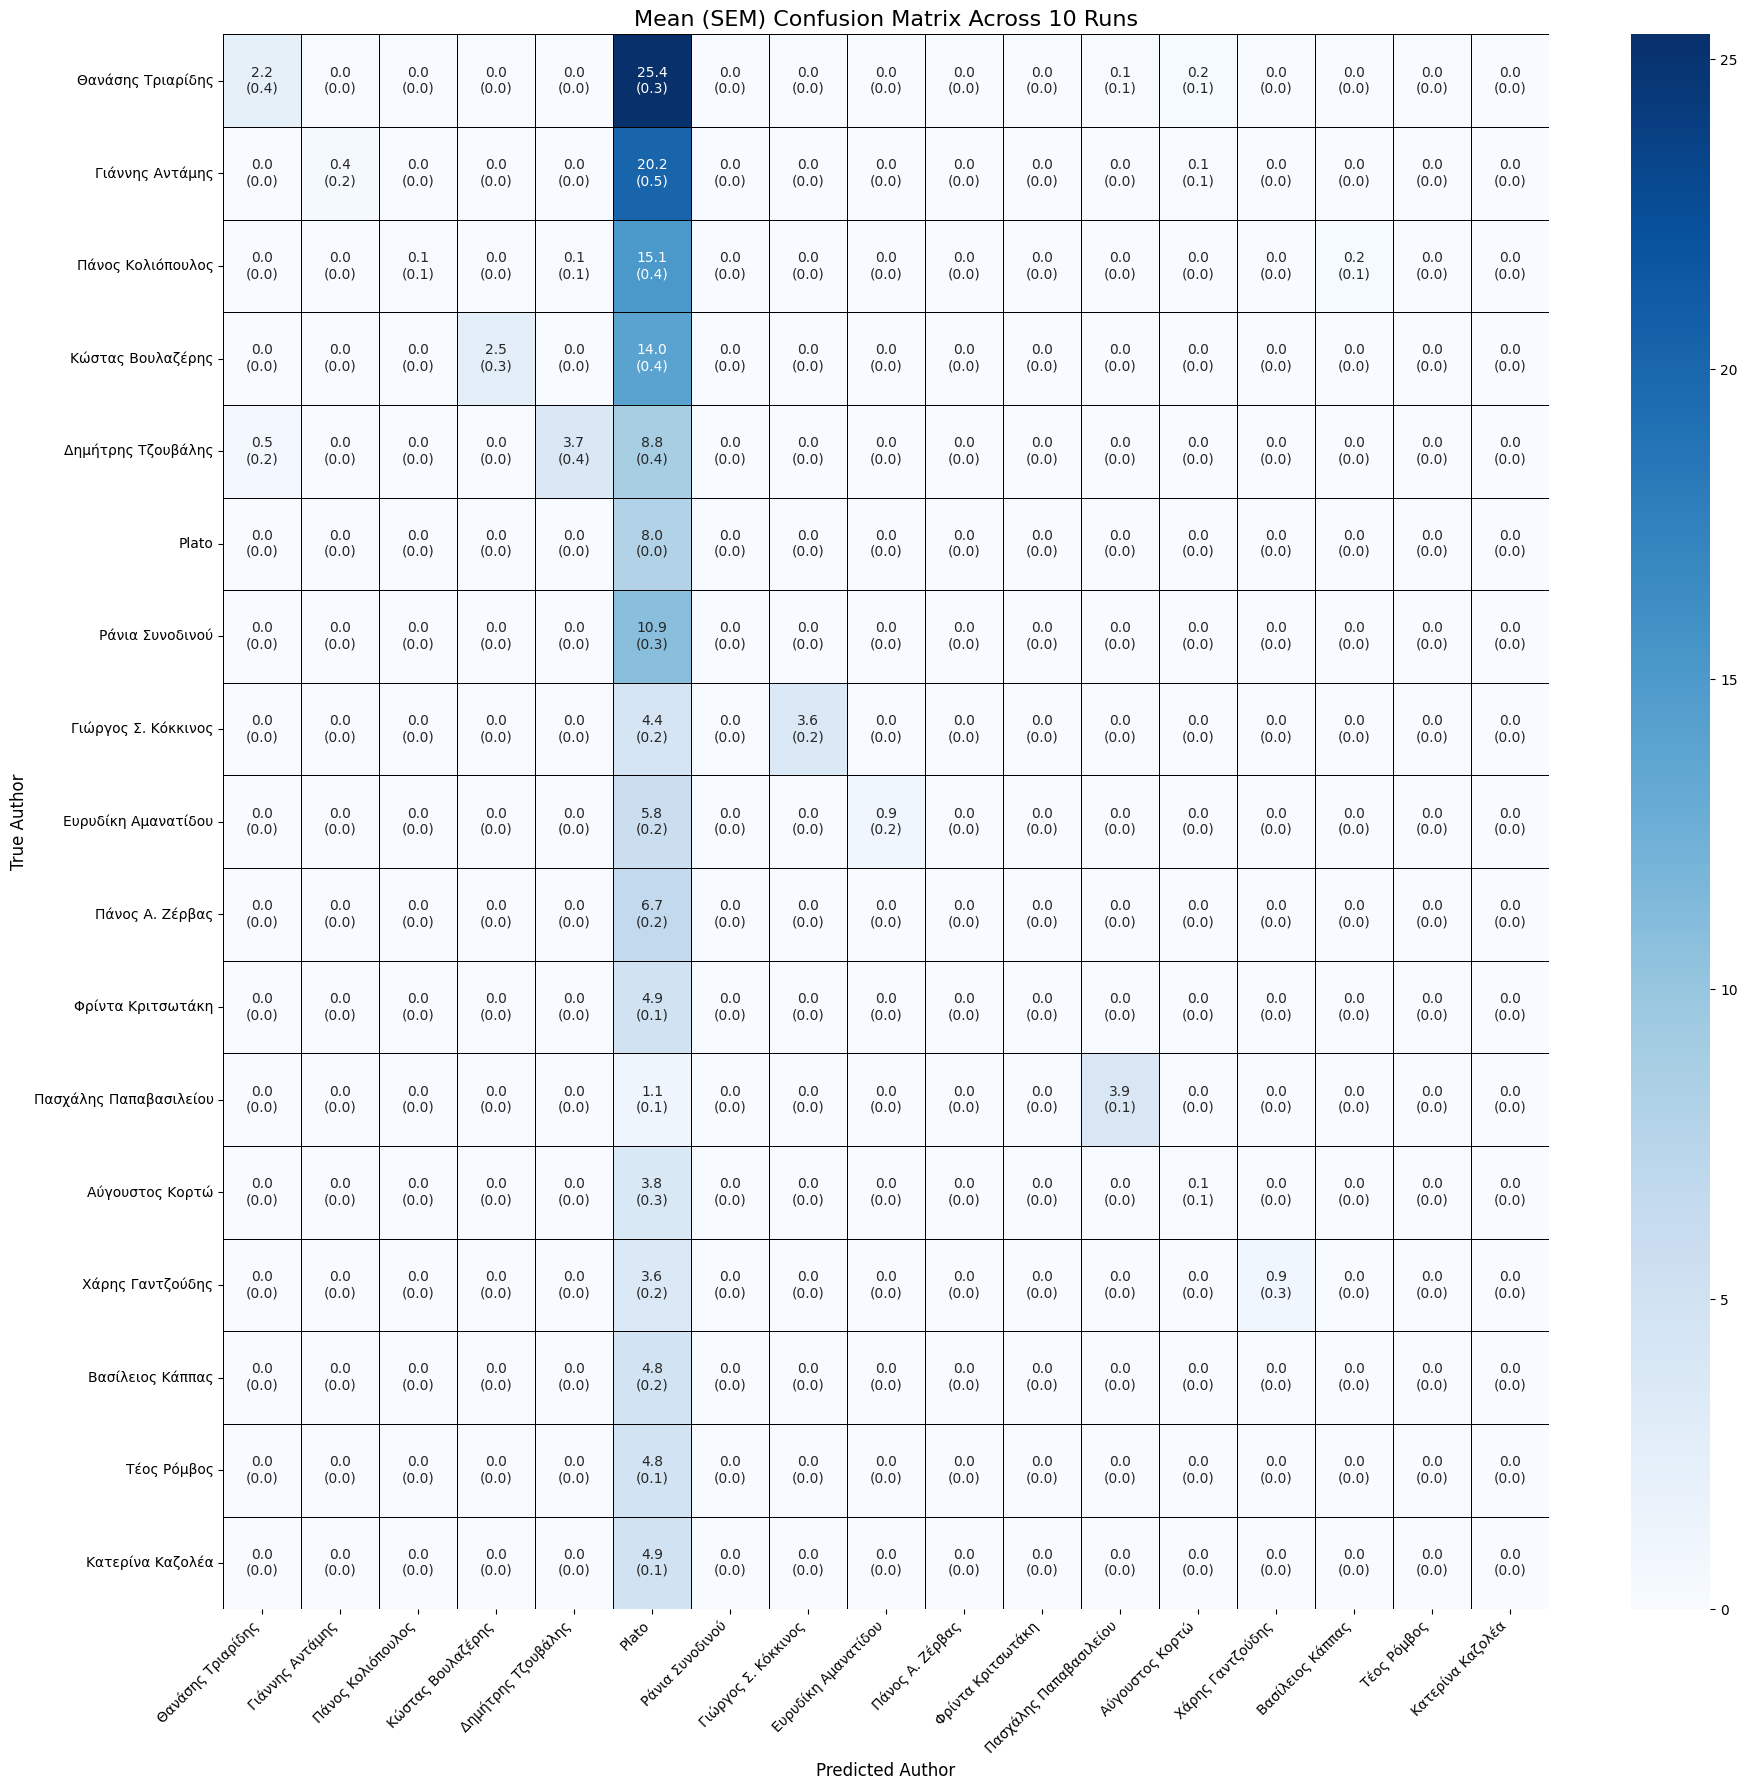

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Assuming pop_authors is defined and barzokas_pop_mini has the 'author' and 'krikri_i' columns
# Also assuming you have run the code to populate `all_cm_arrays` from the previous response

# --- Re-run the confusion matrix calculation for completeness ---
# 1. Initialize a 3D NumPy array to store all 10 confusion matrices
num_authors = len(pop_authors)
all_cm_arrays = np.zeros((10, num_authors, num_authors), dtype=int)

# 2. Modify the loop to collect the confusion matrix for each run
for i in range(1, 11):
    pred_col = f'krikri_{i}'
    y_true = barzokas_pop_mini['author']
    y_pred = barzokas_pop_mini[pred_col].str.strip()

    # Calculate the confusion matrix for the current run
    cm_i = confusion_matrix(y_true, y_pred, labels=pop_authors)

    # Store the 2D matrix into the 3D array
    all_cm_arrays[i-1] = cm_i

# 3. Calculate Mean and Standard Error of the Mean (SEM)
mean_cm = np.mean(all_cm_arrays, axis=0)
std_cm = np.std(all_cm_arrays, axis=0, ddof=1) # ddof=1 for sample std dev
sem_cm = std_cm / np.sqrt(10) # N = 10 runs
# -------------------------------------------------------------------


# 4. Prepare annotations for the heatmap
# We'll create a new array of strings "Mean (SEM)"
annotations = np.empty_like(mean_cm, dtype=object)
for i in range(num_authors):
    for j in range(num_authors):
        annotations[i, j] = f"{mean_cm[i, j]:.1f}\n({sem_cm[i, j]:.1f})" # Newline for readability


# 5. Create the Heatmap Visualization
plt.figure(figsize=(num_authors + 2, num_authors + 1)) # Adjust size dynamically

sns.heatmap(
    mean_cm,                # The data to color the cells (mean counts)
    annot=annotations,      # The custom annotations (Mean (SEM))
    fmt='s',                # Format as string because annotations are strings
    cmap='Blues',           # Color map
    cbar=True,              # Show color bar
    linewidths=.5,          # Lines between cells
    linecolor='black',      # Color of lines
    xticklabels=pop_authors,
    yticklabels=pop_authors
)

plt.title('Mean (SEM) Confusion Matrix Across 10 Runs', fontsize=16)
plt.xlabel('Predicted Author', fontsize=12)
plt.ylabel('True Author', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

https://gemini.google.com/share/62c59af9933f